# Métodos sem malha

## Dados
dados de exemplo: 
 - interpolação: $z = 2x+y^2-xy$
 - EDP: $
 \begin{cases}
 \nabla^2u=0\\
 (x,y) \in (0,1)\times(0,1)\\
 x=0\ \text{ou}\ x=1, \dfrac {\partial u} {\partial y} = 0, \text{Condição de Neumann}\\
 y=0, u=30, \text{Condição de Dirichlet}\\
 y=1, u=80, \text{Condição de Dirichlet}
 \end{cases}
 $

In [97]:
# dados de exemplo para interpolação por mínimos quadrados móveis
interpol_data = [
    [0.520559131078683, 0.062408758274352105, 1.0125256662877162],
    [0.447711576862026, 0.7680861842132574, 1.14149846340328],
    [0.6928072377730861, 0.8192031431762375, 1.4891583985370405],
    [0.16791353130182318, 0.36344468640933736, 0.4068918219549523],
    [0.42633701962624004, 0.1423466043933539, 0.8122489679638201],
    [0.3928812775185744, 0.8308615441039886, 1.1496635156193826],
    [0.8774760430204951, 0.6754122773672129, 1.618475737907712],
    [0.11154008787913916, 0.44871554861818586, 0.37437604760438925],
    [0.9753387832461635, 0.19225053054578867, 1.8001284344465054],
    [0.47016443282445786, 0.9384985267007433, 1.3798597227555374],
    [0.9827866235704859, 0.020709609407733476, 1.9456490079575026],
    [0.6342449242584626, 0.9146502818399507, 1.5249626878582656],
    [0.9966107320409124, 0.780033531403195, 1.8242839854469677],
    [0.34042822889549673, 0.4758376538526644, 0.7452893608721505],
    [0.781028820398589, 0.6373060739643224, 1.4704622615277858],
    [0.7915660098236119, 0.19259682552009116, 1.4677724561660073],
    [0.3011828746881986, 0.8125033388889318, 1.0178153337817315],
    [0.13635614275310148, 0.07406366364688477, 0.2680986762859495]
]

# dados de exemplo para solução de E.D.P utilizando método da colocação
pde_data = [
    [0,0],
    [0,1],
    [1,0],
    [1,1],
    [1,.5],
    [.5,0],
    [0,.5],
    [.5,1],
];

base = ["1","x","x**2","y","y**2","x*y"];
Dbase = ["0","0","2","0","2","0"];
def b(r):
    if r[0] == 0 or r[0]==1 or r[1]==0 or r[1] == 1:# se o ponto está no contorno
        return (r[0]+r[1])/2;
    return 0

## Dependências

In [2]:
%matplotlib notebook

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Gaussiana com raio
$$
w = 
\begin{cases}
\dfrac{{e^{-({\frac{|d|}c})^2}} - {e^{-({\frac r c})^2}}}{1-{e^{-({\frac{r}c})^2}}}, d<r
\\
0, d > r
\end{cases}
$$

In [3]:
def gaussian_with_radius(dist,r):
    c=100
    if la.norm(dist) <= r:
        exp1 = np.exp(-(la.norm(dist)/c)**2)
        exp2 = np.exp(-(r/c)**2)
        weight = ( exp1 - exp2 )/(1-exp2)
    else:
        weight = 0
    return weight

## Pesos $W$

In [4]:
def W(data,point,r):
    W=[]
    for index,row in enumerate(data):
        d2d = row[0:2]
        leftZeroes = np.zeros([1,index])
        rightZeroes = np.zeros([1,len(data) - index - 1])
        weight = gaussian_with_radius(np.subtract(d2d,point),r)
        newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
        W.append(newRow)
    return W

## Matriz de Base $P$

In [50]:
def create_base(base,data):
    P=[]
    for dat in data:
        row = []
        for b in base:
            exec("x=%s"%dat[0])
            exec("y=%s"%dat[1])
            row.append(eval(b))
        P.append(row)
    return P

## Coeficientes $\varphi$
$$
B(x) = P^TW(x)\\
A(x) = B(x)P = P^TW(x)P\\
\varphi^T(x)=p^TA^{-1}(x)B(x)
$$

In [52]:
class LittleDet(Exception):
    def __init__(self, m):
        self.message = m
    def __str__(self):
        return self.message

def coefficients(data,P, x,r,base):
    B = np.matmul(np.transpose(P),W(data,x,r))
    A = np.matmul(B,P)
    det = la.det(A)
    p = create_base(base,[x])
    if(abs(det) < 1e-6):
        raise LittleDet("determinante muito pequeno!")
    else:
        AB= np.matmul(la.inv(A),B)
    return np.matmul(p,AB)
        


## Raio mínimo $R$
parâmetros:
 - `data`: conjunto de dados
 - `points`: pontos de referência
 - `m`: quantidade de pontos no suporte

In [53]:
def get_radius(data,point,m):
    distances = []
    for dat in data:
        dif = np.subtract(point,dat[0:2])
        dist = la.norm(dif)
        distances.append(dist)
    distances = sorted(distances);
    return distances[m]

## Função de aproximação $ũ$

In [54]:
def approx(data,base,point):
    m = len(base);
    while True:
        try:
            r = get_radius(data,point,m)
            P = create_base(base,data)
            c  = coefficients(data,P,point,r,base)
            u=np.array([z for x,y,z  in data])
            break;
        except LittleDet:
            m+=1;
    return np.matmul(c,u);


## Execução

<IPython.core.display.Javascript object>


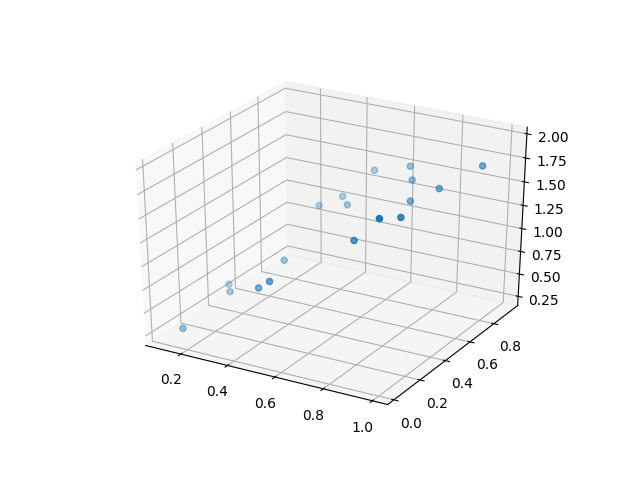

<IPython.core.display.Javascript object>


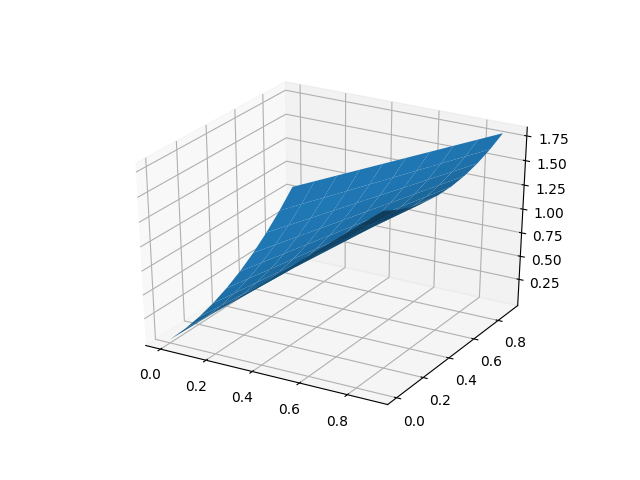

In [93]:
xs = [x for x,y,z in interpol_data]
ys = [y for x,y,z in interpol_data]
zs = [z for x,y,z in interpol_data]

fig = plt.figure("dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)


fig = plt.figure("aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ approx(interpol_data,base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

## Método da colocação
Sejam $x_1 \dots x_n$ $n$ pontos no domínio sujeitos a equação $\mathcal L u(x) = b(x)$ e $x_{n+1} \dots x_{n+m}$ $m$ pontos no contorno sujeitos as equações $\mathcal L_k c(x) = b_k(x)$


$$
\begin{aligned}
(\mathcal L \varphi)&*&\mathbf u &= &\mathbf b\\
\left[
\begin{matrix}
\mathcal L \varphi_1(x_1) & \dots & \mathcal L \varphi_n(x_1)&\mathcal L_1 \varphi_{n+1}(x_1)&\dots & \mathcal L_m \varphi_{n+m}(x_1)\\
&\vdots&&&\vdots\\
\mathcal L \varphi_1(x_n)& \dots & \mathcal L \varphi_n(x_n)&\mathcal L_1 \varphi_n(x_n)&\dots & \mathcal L_m \varphi_n(x_n)\\
\mathcal L_1 \varphi_1(x_{n+1}) & \dots & \mathcal L_1 \varphi_n(x_{n+1})&\mathcal L_1 \varphi_{n+1}(x_{n+1})&\dots & \mathcal L_1 \varphi_{n+m}(x_{n+1})\\
&\vdots&&&\vdots \\
\mathcal L_m \varphi_1(x_{n+m}) & \dots & \mathcal L_m \varphi_n(x_{n+m})&\mathcal L_m \varphi_{n+1}(x_{n+m})&\dots & \mathcal L_m \varphi_{n+m}(x_{n+m})
\end{matrix}
\right]&*
&\left[
\begin{matrix}
u_1\\ \vdots \\ u_n\\ u_{n+1} \\ \vdots \\ u_{n+m}
\end{matrix}
\right] &=
&\left[
\begin{matrix}
b(x_1) \\ \vdots \\ b(x_n) \\ b_1(x_{n+1}) \\ \vdots \\ b_m(x_{n+m})
\end{matrix}
\right]
\end{aligned}
$$

In [84]:
lphi = []
for x,y,z in data:
    point = [x,y]
    m = len(base);
    while True:
        try:
            r = get_radius(data,point,m)
            P = create_base(base,data)
            c  = coefficients(data,P,point,r,base)
            break;
        except LittleDet:
            m+=1;
    lphi.append(c[0]);

bb = [b(r) for r in data]

In [88]:
print(np.matmul(la.inv(lphi),bb))
print(bb)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
